In [1]:
# Final Project                        
# FIN7032 Quantitative Equity Investing                                       
# Vighnesh Raj                                        

# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read monthly stock file
msf = pd.read_csv('Data/msf_6123.csv')

# Format date variable
msf['date'] = pd.to_datetime(msf['date'], format='%Y%m%d')
msf['year'] = msf['date'].dt.year
msf['quarter'] = msf['date'].dt.quarter
msf['month'] = msf['date'].dt.month

# Market Cap
msf['MC'] = msf.prc*msf.shrout/1000

# Begin-of-month MC (as portfolio weights)
msf['MC_beg'] = msf.groupby('permno')['MC'].shift(1)

# Read predictive signals updated at calendar quarter-end, as well as variables for liquidity screens
signals = pd.read_csv('Data/signals_quarterly.csv')

# Format date variable
signals['date'] = pd.to_datetime(signals['date'], format='%Y%m%d')
signals['year'] = signals['date'].dt.year
signals['quarter'] = signals['date'].dt.quarter

# Variables
# permno ~ unique stock ID
# date ~ last trading day in a calendar quarter (consistent with date in msf)
# prc ~ share price (at quarter-end)
# MC ~ market capitalization at quarter-end ($Bil)
# DTV ~ average daily trading volume ($Mil) druing the past 6 months
# BM ~ book-to-market (updated using the latest quarterly accounting statements and quarter-end ME)
# R11 ~ momentum (past 12-to-2-month cumulative return)
# IA ~ investment-to-asssets (trailing 4-quarter asset growth using the latest quarterly accounting statements)
# ROE ~ return on equity (based on the most recent announced quarterly earnings report)
# beta ~ market beta (based on returns during the past 60 months)
# vol ~ daily return volatility (%, based on daily returns in the most recent month)

# For the signals, be clear about whether it "positively" or "negatively" predicts future returns
# positively: BM, R11, ROE
# negatively: IA
# Size/liquidity screens: MC, DTV
# Risk controls: beta, vol

#### Step 1: Select eligible stocks that meet size and liquidity requirements

In [3]:
# Require needed signal(s)
# To reduce trading costs and volatility, drop stocks with share price below $5 at quarter-end
sample1 = signals[(signals.vol.notna()) & (signals.R11.notna()) & (signals.ROE.notna()) & (signals.prc>=5)][['permno','date','year','quarter','DTV','MC','vol','R11','ROE']]

# Identify the top-1000 stocks by MC
# At each quarter-end, rank stocks by MC from largest to smallest
sample1['rank_MC'] = sample1.groupby('date').MC.rank(ascending=False)
sample1['rank_MC'] = sample1.rank_MC.astype(int)

# Identify the top-1000 stocks by trading volume
# At each quarter-end, rank stocks by DTV from highest to lowest
sample1['rank_DTV'] = sample1.groupby('date').DTV.rank(ascending=False)
sample1['rank_DTV'] = sample1.rank_DTV.astype(int)

# Select stocks among top-1000 in both MC and DTV
sample1 = sample1[(sample1.rank_MC<=1000) & (sample1.rank_DTV<=1000)]

sample1.describe()


,permno,date,year,quarter,DTV,MC,vol,R11,ROE,rank_MC,rank_DTV
count,102766.000000,102766,102766.000000,102766.000000,102766.000000,102766.000000,102766.000000,102766.000000,102766.000000,102766.000000,102766.000000
mean,55760.675885,2009-03-18 04:56:47.819707136,2008.588035,2.511113,134.436001,19.094618,2.143703,0.230704,-0.084207,446.017730,450.379299
min,10032.000000,1993-12-31 00:00:00,1993.000000,1.000000,1.443920,0.571612,0.032311,-0.949830,-6804.500000,1.000000,1.000000
25%,24256.000000,2001-09-28 00:00:00,2001.000000,2.000000,22.129898,2.903143,1.235805,-0.057256,0.015678,213.000000,214.000000
50%,62148.000000,2009-06-30 00:00:00,2009.000000,3.000000,49.078496,5.674465,1.743708,0.134728,0.034440,428.000000,432.000000
75%,82307.000000,2016-09-30 00:00:00,2016.000000,4.000000,120.785933,14.276854,2.544290,0.362340,0.056838,663.000000,673.000000
max,93436.000000,2023-12-29 00:00:00,2023.000000,4.000000,29356.666587,3035.216956,58.690419,66.000004,190.983240,1000.000000,1000.000000
std,28749.374695,NaN,8.697040,1.121547,486.690972,62.421561,1.512898,0.800353,30.075073,272.835921,275.897364


In [4]:
# Check the sample size
# Number of stocks per quarter-end
nstocks = sample1.groupby('date').permno.count()
nstocks.describe()

count    121.000000
mean     849.305785
std       27.910226
min      791.000000
25%      822.000000
50%      857.000000
75%      873.000000
max      909.000000
Name: permno, dtype: float64

#### Step 2: Rank each signal individually then select top 100 stocks by average of 3 signal ranking

In [6]:
sample1['rank_vol'] = sample1.groupby('date')['vol'].rank(ascending=True).astype(int)   # Lower vol better
sample1['rank_R11'] = sample1.groupby('date')['R11'].rank(ascending=False).astype(int)   # High Momentum better
sample1['rank_ROE'] = sample1.groupby('date')['ROE'].rank(ascending=False).astype(int)   # Higher ROE better

sample1['avg_rank'] = sample1[['rank_vol', 'rank_R11', 'rank_ROE']].mean(axis=1)

sample1['rank_score'] = sample1.groupby('date')['avg_rank'].rank(ascending=True).astype(int)

sample2 = sample1[sample1.rank_score <= 100].rename(columns={'year':'ryear','quarter':'rquarter'}).reset_index(drop=True)


print(sample2[sample2.date=='2023-12-29'])

       permno       date  ryear  rquarter          DTV           MC       vol  \
74      10107 2023-12-29   2023         4  8703.812709  2794.827802  0.920738   
173     10220 2023-12-29   2023         4    41.015811     7.021792  1.342937   
468     11403 2023-12-29   2023         4   338.744131    74.101527  1.438857   
535     11618 2023-12-29   2023         4   189.508125    37.010420  0.708082   
654     11955 2023-12-29   2023         4   242.833606    72.137002  0.927438   
...       ...        ...    ...       ...          ...          ...       ...   
11730   91556 2023-12-29   2023         4   268.318655    46.630787  0.994368   
11776   91849 2023-12-29   2023         4    91.912865    24.205870  0.805455   
11841   92221 2023-12-29   2023         4   599.929914    79.457062  1.282687   
11931   92611 2023-12-29   2023         4  1350.712647   412.010123  0.677023   
12043   93089 2023-12-29   2023         4   216.090859    34.631595  1.527545   

            R11       ROE  

#### Step 3: Compute value-weighted monthly fund returns during the coming quarter

In [8]:
ret = msf[['permno','year','quarter','month','ret','MC_beg']][msf.year>=1994].reset_index(drop=True)

# Drop obs. with missing monthly returns or MC_beg
ret = ret[ret.ret.notna() & ret.MC_beg.notna()].reset_index(drop=True)

# Fund rebalancing/ranking year/quarter
# Lag year-quarter in monthly return files by 1 quarter (becuase that's when we select the 100 stocks)
ret.loc[ret.quarter>1,'ryear'] = ret.year
ret.loc[ret.quarter>1,'rquarter'] = ret.quarter-1

ret.loc[ret.quarter==1,'ryear'] = ret.year-1
ret.loc[ret.quarter==1,'rquarter'] = 4

print(ret)

# Merge quarter-end sample with monthly returns during the coming quarter
ret2 = pd.merge(ret, sample2[['permno','ryear','rquarter']], on=['permno','ryear','rquarter'])

print(ret2)

         permno  year  quarter  month       ret      MC_beg   ryear  rquarter
0         10001  1994        1      1 -0.047619    0.020053  1993.0       4.0
1         10001  1994        1      2  0.000000    0.019093  1993.0       4.0
2         10001  1994        1      3 -0.004286    0.019093  1993.0       4.0
3         10001  1994        2      4 -0.144928    0.018820  1994.0       1.0
4         10001  1994        2      5  0.067797    0.016092  1994.0       1.0
...         ...   ...      ...    ...       ...         ...     ...       ...
1743039   93436  2023        3      8 -0.034962  848.821215  2023.0       2.0
1743040   93436  2023        3      9 -0.030456  819.144372  2023.0       2.0
1743041   93436  2023        4     10 -0.197346  795.449380  2023.0       3.0
1743042   93436  2023        4     11  0.195379  638.454494  2023.0       3.0
1743043   93436  2023        4     12  0.034988  763.195354  2023.0       3.0

[1743044 rows x 8 columns]
       permno  year  quarter  month 

In [9]:
# Weighted Average Function
def wt_avg(data, var_name, wt_name):
    d = data[var_name]
    w = data[wt_name]
    wt_avg = (d * w).sum() / w.sum()
    n = d.count()
    try:
        return pd.Series([wt_avg, n])
    except ZeroDivisionError:
        return np.nan

# Value-weighted fund portfolio return
ret_fund = ret2.groupby(['year','month'])\
               .apply(wt_avg, 'ret', 'MC_beg').reset_index()\
               .rename(columns={0:'ret_fund', 1:'nstocks'})

ret_fund.nstocks = ret_fund.nstocks.astype(int)
ret_fund = ret_fund[['year','month','nstocks','ret_fund']]

print(ret_fund)

     year  month  nstocks  ret_fund
0    1994      1      100  0.033686
1    1994      2      100 -0.030674
2    1994      3      100 -0.046568
3    1994      4      100 -0.001109
4    1994      5      100  0.010273
..    ...    ...      ...       ...
355  2023      8       97 -0.002237
356  2023      9       97 -0.048084
357  2023     10       99 -0.006097
358  2023     11       98  0.096697
359  2023     12       98  0.031786

[360 rows x 4 columns]


/var/folders/86/h8k6zfgd2g14g9f0xvxh0rxr0000gn/T/ipykernel_49600/2192599681.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(wt_avg, 'ret', 'MC_beg').reset_index()\


In [10]:
# Summary stats
ret_fund.describe()

,year,month,nstocks,ret_fund
count,360.000000,360.000000,360.000000,360.000000
mean,2008.500000,6.500000,97.905556,0.009955
std,8.667488,3.456857,2.026832,0.042401
min,1994.000000,1.000000,84.000000,-0.165483
25%,2001.000000,3.750000,97.000000,-0.014775
50%,2008.500000,6.500000,98.000000,0.012315
75%,2016.000000,9.250000,99.000000,0.035821
max,2023.000000,12.000000,102.000000,0.143057


In [11]:
# Compounded returns within each calendar year
ret_fund['logret_fund'] = np.log(1+ret_fund.ret_fund)
ret_fund_ann = ret_fund.groupby(['year'])['logret_fund'].sum().reset_index()
ret_fund_ann['ret_fund'] = np.exp(ret_fund_ann.logret_fund)-1

# Summary Stats
ret_fund_ann.ret_fund.describe()

count    30.000000
mean      0.127225
std       0.168467
min      -0.292610
25%       0.046805
50%       0.110282
75%       0.272647
max       0.423967
Name: ret_fund, dtype: float64

#### Step 4: Use the S&P 500 index as the benchmark

In [13]:
# Read monthly S&P 500 index total returns
spxt = pd.read_csv('Data/spxt_9423.csv')
ret_spxt = spxt[['year','month','spxt']].rename(columns={'spxt':'ret_spxt'})

# Compounded returns within each calendar year for SPX
ret_spxt['logret_spxt'] = np.log(1+ret_spxt.ret_spxt)
ret_spxt_ann = ret_spxt.groupby(['year'])['logret_spxt'].sum().reset_index()
ret_spxt_ann['ret_spxt'] = np.exp(ret_spxt_ann['logret_spxt'])-1

ret_spxt_ann.ret_spxt.describe()

count    30.000000
mean      0.117970
std       0.182949
min      -0.370023
25%       0.015851
50%       0.154282
75%       0.264034
max       0.375884
Name: ret_spxt, dtype: float64

#### Step 5: Evaluate Fund Performance

##### Step 5.1 Plot the time-series of annual fund performance

<Axes: title={'center': 'Annual Returns of the Strategic Quality-Momentum Fund (1994-2023)'}, xlabel='year'>

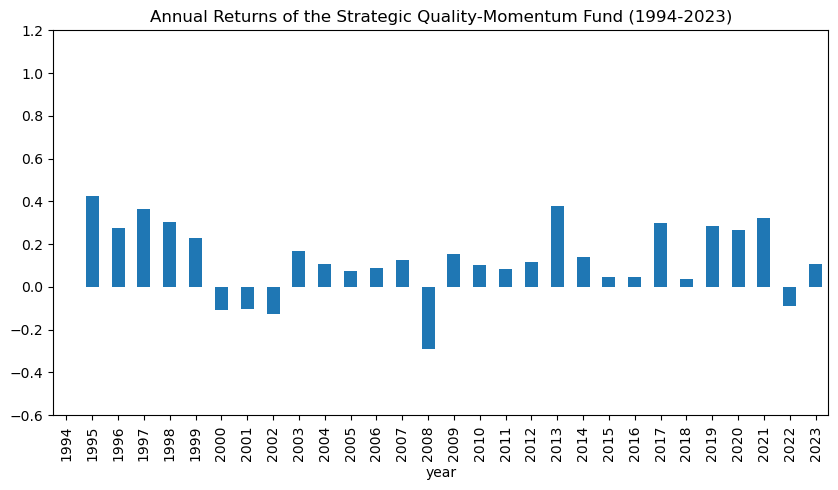

In [16]:
# Plot a bar chart for the time series
ret_fund_ann.plot(kind='bar', figsize=(10,5), x='year', y='ret_fund', ylim=(-0.6, 1.2), legend=False,\
                  title='Annual Returns of the Strategic Quality-Momentum Fund (1994-2023)')

##### Step 5.2: Compare with the benchmark index using annual returns

In [18]:
# Compounded risk-free rate within each calendar year
msi = pd.read_csv('Data/msi_6123.csv')
msi['logrf'] = np.log(1+msi.rf)
rf_ann = msi.groupby(['year'])['logrf'].sum().reset_index()
rf_ann['rf_ann'] = np.exp(rf_ann.logrf)-1

# Strategic Equity Opportunities Fund

# Excess annual returns
ret_fund_ann = pd.merge(ret_fund_ann, rf_ann, on=['year'])
ret_fund_ann['exret_fund'] = ret_fund_ann.ret_fund - ret_fund_ann.rf_ann

# Mean, Volatility, and the Sharpe ratio
print("SQMF - Average annual excess return (%):", "{:.2f}".format(ret_fund_ann.exret_fund.mean()*100))
print("SQMF - Annual excess return volatility (%):", "{:.2f}".format(ret_fund_ann.exret_fund.std()*100))
print("SQMF - Annual Sharpe Ratio:", "{:.2f}".format(ret_fund_ann.exret_fund.mean()/ret_fund_ann.exret_fund.std()))

SQMF - Average annual excess return (%): 10.44
SQMF - Annual excess return volatility (%): 16.82
SQMF - Annual Sharpe Ratio: 0.62


In [19]:
# Benchmark Index
ret_spxt_ann = pd.merge(ret_spxt_ann, rf_ann, on=['year'])
ret_spxt_ann['exret_spxt'] = ret_spxt_ann.ret_spxt - ret_spxt_ann.rf_ann

print("S&P500 - Average annual excess return (%):", "{:.2f}".format(ret_spxt_ann.exret_spxt.mean()*100))
print("S&P500 - Annual excess return volatility (%):", "{:.2f}".format(ret_spxt_ann.exret_spxt.std()*100))
print("S&P500 - Annual Sharpe Ratio:", "{:.2f}".format(ret_spxt_ann.exret_spxt.mean()/ret_spxt_ann.exret_spxt.std()))

S&P500 - Average annual excess return (%): 9.52
S&P500 - Annual excess return volatility (%): 18.23
S&P500 - Annual Sharpe Ratio: 0.52


In [20]:
#1-year compounded returns
print("1-year compounded annual return of SQMF (%):", 
      "{:.2f}".format((np.exp(ret_fund_ann[ret_fund_ann.year == 2023].logret_fund.sum()) - 1) * 100))

print("1-year compounded annual return of Benchmark Index (%):", 
      "{:.2f}".format((np.exp(ret_spxt_ann[ret_spxt_ann.year == 2023].logret_spxt.sum()) - 1) * 100))


# 3-year compounded returns
print("3-year compounded annual return of SQMF (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=2019].logret_fund.sum())**(1/3))-1)*100))
print("3-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_spxt_ann[ret_spxt_ann.year>=2019].logret_spxt.sum())**(1/3))-1)*100))

# 5-year compounded returns
print("5-year compounded annual return of SQMF (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=2019].logret_fund.sum())**(1/5))-1)*100))
print("5-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_spxt_ann[ret_spxt_ann.year>=2019].logret_spxt.sum())**(1/5))-1)*100))

# 10-year compounded returns
print("10-year compounded annual return of SQMF (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann[ret_fund_ann.year>=2019].logret_fund.sum())**(1/10))-1)*100))
print("10-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_spxt_ann[ret_spxt_ann.year>=2019].logret_spxt.sum())**(1/10))-1)*100))

# 30-year compounded returns
print("30-year compounded annual return of SQMF (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann.logret_fund.sum())**(1/30))-1)*100))
print("30-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_spxt_ann.logret_spxt.sum())**(1/30))-1)*100))

1-year compounded annual return of SQMF (%): 10.57
1-year compounded annual return of Benchmark Index (%): 26.27
3-year compounded annual return of SQMF (%): 29.35
3-year compounded annual return of Benchmark Index (%): 27.50
5-year compounded annual return of SQMF (%): 16.70
5-year compounded annual return of Benchmark Index (%): 15.69
10-year compounded annual return of SQMF (%): 8.03
10-year compounded annual return of Benchmark Index (%): 7.56
30-year compounded annual return of SQMF (%): 11.43
30-year compounded annual return of Benchmark Index (%): 10.15


In [21]:
# 30-year compounded returns
print("30-year compounded annual return of SQMF (%):",\
      "{:.2f}".format(((np.exp(ret_fund_ann.logret_fund.sum())**(1/30))-1)*100))
print("30-year compounded annual return of Benchmark Index (%):",\
      "{:.2f}".format(((np.exp(ret_spxt_ann.logret_spxt.sum())**(1/30))-1)*100))

30-year compounded annual return of SQMF (%): 11.43
30-year compounded annual return of Benchmark Index (%): 10.15


##### Step 5.3: Evaluate the monthly fund returns using factor models

In [23]:
# Regression (CAPM and FF3)
FF3 = pd.read_csv('Data/FF3_ds.csv')
reg_fund = pd.merge(ret_fund, FF3, on=['year','month'])
reg_fund['exret_fund'] = reg_fund.ret_fund - reg_fund.rf

# CAPM
ols_capm = sm.ols('exret_fund ~ MKT', data=reg_fund)
est_capm = ols_capm.fit()
print(est_capm.summary())

                            OLS Regression Results                            
Dep. Variable:             exret_fund   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     934.8
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          7.49e-102
Time:                        00:06:57   Log-Likelihood:                 858.43
No. Observations:                 360   AIC:                            -1713.
Df Residuals:                     358   BIC:                            -1705.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.001      2.226      0.0

In [24]:
# FF3
ols_ff3 = sm.ols('exret_fund ~ MKT+SMB+HML', data=reg_fund)
est_ff3 = ols_ff3.fit()
print(est_ff3.summary())

                            OLS Regression Results                            
Dep. Variable:             exret_fund   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     379.7
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          1.53e-110
Time:                        00:06:57   Log-Likelihood:                 885.61
No. Observations:                 360   AIC:                            -1763.
Df Residuals:                     356   BIC:                            -1748.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.001      2.402      0.0

In [25]:
# End-of-2023 Portfolio Weights
top = sample2[['permno','MC','rank_score']][(sample2.ryear==2023) & (sample2.rquarter==4)]
top['wt'] = top.MC / top.MC.sum()

# Merge with stock ticker
ticker = msf[(msf.year==2023) & (msf.month==12)][['permno','ticker','exchcd']]
top = pd.merge(top, ticker, on='permno')

# Sort by portfolio weight
top = top.sort_values('wt', ascending=False).reset_index(drop=True)
top.head(10)

,permno,MC,rank_score,wt,ticker,exchcd
0,14593,2994.371343,2,0.206850,AAPL,3
1,10107,2794.827802,4,0.193066,MSFT,3
2,84788,1570.152670,38,0.108466,AMZN,3
3,86580,1223.193400,36,0.084498,NVDA,3
4,13407,785.652094,35,0.054273,META,3
5,47896,491.760461,99,0.033971,JPM,1
6,92611,412.010123,17,0.028462,V,1
7,91233,396.841111,15,0.027414,MA,1
8,66181,344.908046,98,0.023826,HD,1
9,76076,205.286808,92,0.014181,CSCO,3


#### Cumulative Growth Portfolio on $10,000 from 1994-2023

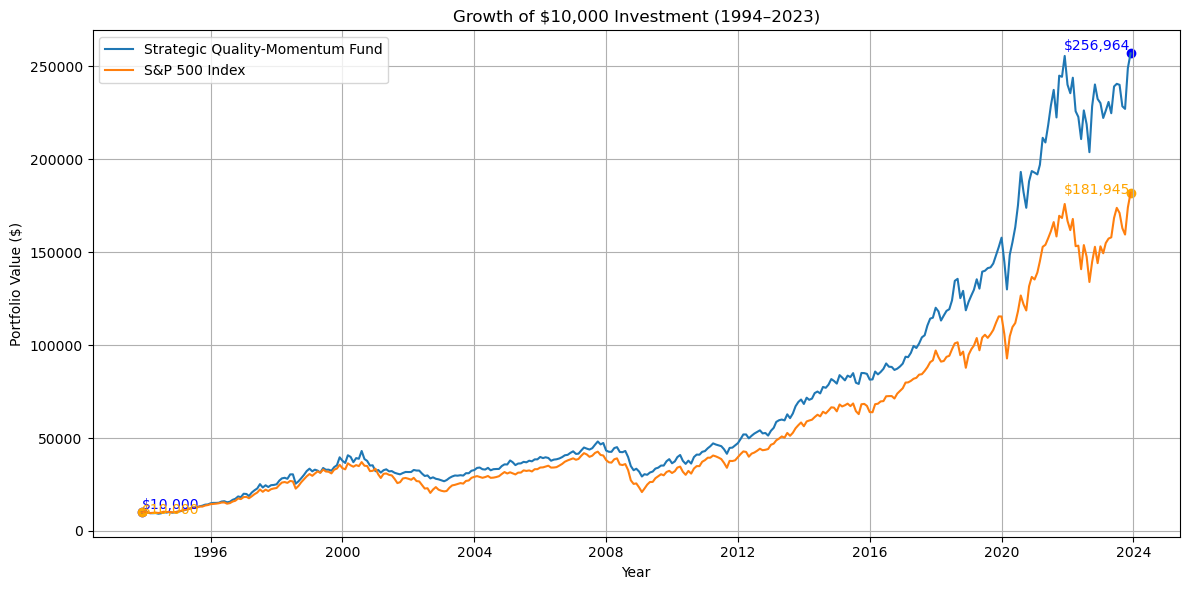

In [27]:
# Set initial investment
initial_investment = 10000

# Fund cumulative returns
ret_fund['gross_ret'] = 1 + ret_fund['ret_fund']

# Insert a dummy row at the beginning with gross_ret = 1 (i.e., 0% return)
first_row = pd.DataFrame({
    'gross_ret': [1],
    'ret_fund': [0],
    'year': [1993],  
    'month': [12]    
})
ret_fund = pd.concat([first_row, ret_fund], ignore_index=True)

# Cumulative return calculation
ret_fund['cumulative_return'] = ret_fund['gross_ret'].cumprod()
ret_fund['portfolio_value'] = ret_fund['cumulative_return'] * initial_investment

# Repeat same process for SPX
ret_spxt = pd.read_csv('Data/spxt_9423.csv')
ret_spxt['gross_ret'] = 1 + ret_spxt['spxt']

first_row_spx = pd.DataFrame({
    'gross_ret': [1],
    'spxt': [0],
    'year': [1993],
    'month': [12]
})
ret_spxt = pd.concat([first_row_spx, ret_spxt], ignore_index=True)

ret_spxt['cumulative_return'] = ret_spxt['gross_ret'].cumprod()
ret_spxt['portfolio_value'] = ret_spxt['cumulative_return'] * initial_investment

# Convert year and month into datetime for both datasets
ret_fund['date'] = pd.to_datetime(ret_fund[['year', 'month']].assign(day=1))
ret_spxt['date'] = pd.to_datetime(ret_spxt[['year', 'month']].assign(day=1))


# Now Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ret_fund['date'], ret_fund['portfolio_value'], label='Strategic Quality-Momentum Fund')
plt.plot(ret_spxt['date'], ret_spxt['portfolio_value'], label='S&P 500 Index')

# Annotate start and end points for fund
plt.scatter(ret_fund['date'].iloc[0], ret_fund['portfolio_value'].iloc[0], color='blue')
plt.scatter(ret_fund['date'].iloc[-1], ret_fund['portfolio_value'].iloc[-1], color='blue')
plt.text(ret_fund['date'].iloc[0], ret_fund['portfolio_value'].iloc[0], f"${ret_fund['portfolio_value'].iloc[0]:,.0f}", color='blue', ha='left', va='bottom')
plt.text(ret_fund['date'].iloc[-1], ret_fund['portfolio_value'].iloc[-1], f"${ret_fund['portfolio_value'].iloc[-1]:,.0f}", color='blue', ha='right', va='bottom')

# Annotate start and end points for SPX
plt.scatter(ret_spxt['date'].iloc[0], ret_spxt['portfolio_value'].iloc[0], color='orange')
plt.scatter(ret_spxt['date'].iloc[-1], ret_spxt['portfolio_value'].iloc[-1], color='orange')
plt.text(ret_spxt['date'].iloc[0], ret_spxt['portfolio_value'].iloc[0] + 5000, f"${ret_spxt['portfolio_value'].iloc[0]:,.0f}", color='orange', ha='left', va='top')
plt.text(ret_spxt['date'].iloc[-1], ret_spxt['portfolio_value'].iloc[-1] + 5000, f"${ret_spxt['portfolio_value'].iloc[-1]:,.0f}", color='orange', ha='right', va='top')

# Titles and labels
plt.title('Growth of $10,000 Investment (1994–2023)')
plt.xlabel('Year')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Drawdown Plot

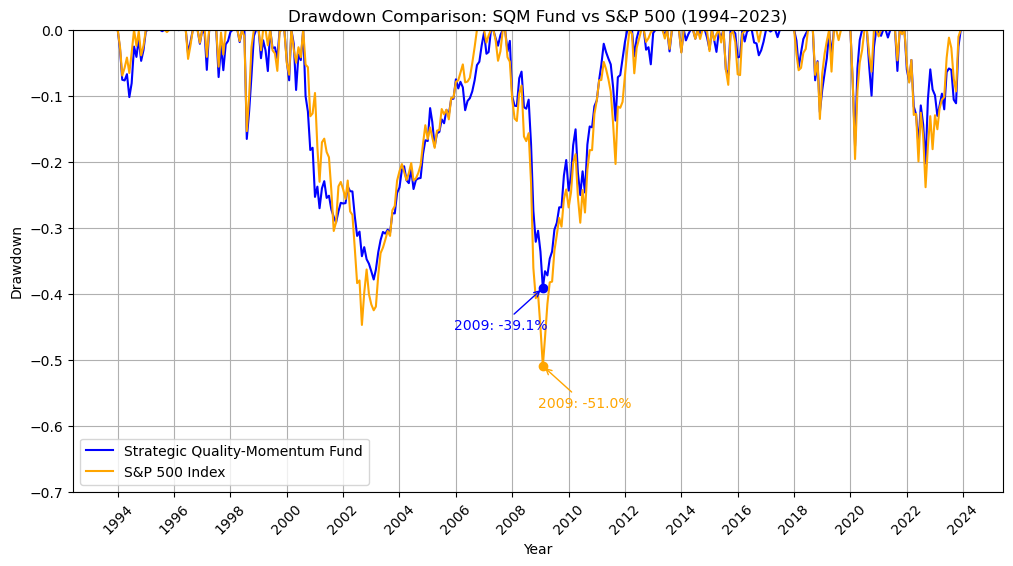

In [29]:
# Create date column using year and month in ret_fund
ret_fund['date'] = pd.to_datetime(ret_fund[['year', 'month']].assign(day=1))
ret_spxt['date'] = pd.to_datetime(ret_spxt[['year', 'month']].assign(day=1))

# Calculate running maximum
ret_fund['running_max'] = ret_fund['portfolio_value'].cummax()
ret_fund['drawdown'] = (ret_fund['portfolio_value'] - ret_fund['running_max']) / ret_fund['running_max']

ret_spxt['running_max'] = ret_spxt['portfolio_value'].cummax()
ret_spxt['drawdown'] = (ret_spxt['portfolio_value'] - ret_spxt['running_max']) / ret_spxt['running_max']

# 1. Find Fund minimum drawdown and its date
fund_min_drawdown = ret_fund['drawdown'].min()
fund_min_date = ret_fund.loc[ret_fund['drawdown'].idxmin(), 'date']

# 2. Find SPX minimum drawdown and its date
spx_min_drawdown = ret_spxt['drawdown'].min()
spx_min_date = ret_spxt.loc[ret_spxt['drawdown'].idxmin(), 'date']

# 3. Plot Drawdowns
plt.figure(figsize=(12,6))
plt.plot(ret_fund['date'], ret_fund['drawdown'], label='Strategic Quality-Momentum Fund', color='blue')
plt.plot(ret_spxt['date'], ret_spxt['drawdown'], label='S&P 500 Index', color='orange')

# 4. Annotate Fund Minimum Drawdown
plt.scatter(fund_min_date, fund_min_drawdown, color='blue')
plt.annotate(f"{fund_min_date.year}: {fund_min_drawdown:.1%}",
             (fund_min_date, fund_min_drawdown),
             textcoords="offset points", xytext=(-30, -30), ha='center', color='blue',
             arrowprops=dict(arrowstyle="->", color='blue'))

# 5. Annotate SPX Minimum Drawdown
plt.scatter(spx_min_date, spx_min_drawdown, color='orange')
plt.annotate(f"{spx_min_date.year}: {spx_min_drawdown:.1%}",
             (spx_min_date, spx_min_drawdown),
             textcoords="offset points", xytext=(30, -30), ha='center', color='orange',
             arrowprops=dict(arrowstyle="->", color='orange'))


plt.title('Drawdown Comparison: SQM Fund vs S&P 500 (1994–2023)')
plt.xlabel('Year')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.ylim(-0.7, 0)  # Nice range for viewing drawdowns

# X-axis as Years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()
